In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim

Neural Network (Hidden 8) - Training RMSE: 1.4535, Validation RMSE: 1.4299
Neural Network (Hidden 16) - Training RMSE: 0.8557, Validation RMSE: 0.8234
Neural Network (Hidden 32) - Training RMSE: 0.7085, Validation RMSE: 0.7005
Neural Network (Hidden 64) - Training RMSE: 0.6655, Validation RMSE: 0.6520
Best Neural Network (Hidden 64) - Test RMSE: 0.6910


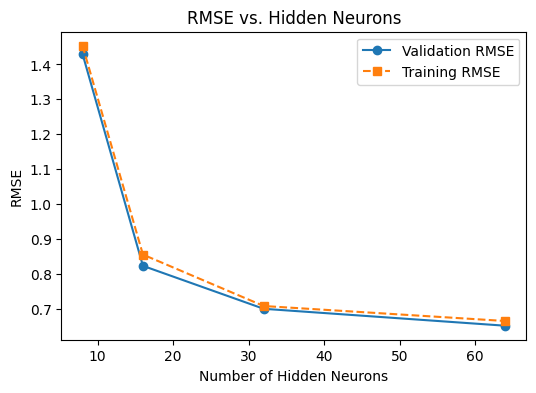

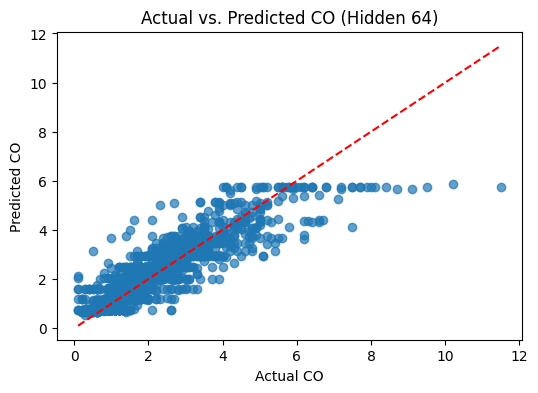

In [10]:
df = pd.read_csv("AirQuality.csv")
train_data, temp_data = train_test_split(df, test_size=0.4, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

X_train, y_train = train_data.iloc[:, :-1].values, train_data["CO"].values
X_val, y_val = val_data.iloc[:, :-1].values, val_data["CO"].values
X_test, y_test = test_data.iloc[:, :-1].values, test_data["CO"].values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, 1) 

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        return x


hidden_sizes = [8, 16, 32, 64]
best_hidden_size = None
best_model_state = None
best_rmse_val = float("inf")

rmse_train_list = []
rmse_val_list = []

for hidden_size in hidden_sizes:
    model = NeuralNet(12, hidden_size)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    num_epochs = 500
    loss_history = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        y_pred_train = model(X_train_tensor)
        loss = criterion(y_pred_train, y_train_tensor)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

   
    with torch.no_grad():
        y_train_pred = model(X_train_tensor)
        rmse_train = np.sqrt(mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy()))
        
        y_val_pred = model(X_val_tensor)
        rmse_val = np.sqrt(mean_squared_error(y_val_tensor.numpy(), y_val_pred.numpy()))

    print(f"Neural Network (Hidden {hidden_size}) - Training RMSE: {rmse_train:.4f}, Validation RMSE: {rmse_val:.4f}")

    rmse_train_list.append(rmse_train)
    rmse_val_list.append(rmse_val)
    if rmse_val < best_rmse_val:
        best_rmse_val = rmse_val
        best_hidden_size = hidden_size
        best_model_state = model.state_dict()


best_model = NeuralNet(12, best_hidden_size)
best_model.load_state_dict(best_model_state)


with torch.no_grad():
    y_test_pred = best_model(X_test_tensor)
    rmse_test = np.sqrt(mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy()))

print(f"Best Neural Network (Hidden {best_hidden_size}) - Test RMSE: {rmse_test:.4f}")


plt.figure(figsize=(6, 4))
plt.plot(hidden_sizes, rmse_val_list, marker='o', linestyle='-', label="Validation RMSE")
plt.plot(hidden_sizes, rmse_train_list, marker='s', linestyle='--', label="Training RMSE")
plt.xlabel("Number of Hidden Neurons")
plt.ylabel("RMSE")
plt.title("RMSE vs. Hidden Neurons")
plt.legend()
plt.show()


plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred.numpy(), alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # 45-degree reference line
plt.xlabel("Actual CO")
plt.ylabel("Predicted CO")
plt.title(f"Actual vs. Predicted CO (Hidden {best_hidden_size})")
plt.show()
